In [1]:

import concurrent.futures

import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap as colorMap
from matplotlib.ticker import PercentFormatter

import pyadditive.additive as pyadditive
from pyadditive.additive_machine import AdditiveMachine
from pyadditive.microstructure import MicrostructureInput
from pyadditive.porosity import PorosityInput
from pyadditive.single_bead import BeadType, SingleBeadInput


In [3]:
additive = pyadditive.launch_additive(ip='localhost', port=50052)
material = additive.get_material('17-4PH') 

INFO:pyadditive.additive:Connected to localhost:50052


In [4]:
# Single bead evaluation
# power range: 50 - 700 (w)
# velocity (aka scan speed) range: .350 - 2.500 (m/s)
power_values = [50, 170, 340, 510, 700]
velocity_values = [.35, 0.75, 1.25, 1.75, 2.25, 2.5]
pv = []
for p in power_values:
  for v in velocity_values:
    pv.append((p,v))
    
results = []
permutations = len(power_values) * len(velocity_values)
with concurrent.futures.ThreadPoolExecutor(4) as executor:
    completed = 0
    futures = []
    for x in pv:
        machine = AdditiveMachine.default()
        machine.laser_power=x[0]
        machine.scan_speed=x[1] 
        input = SingleBeadInput(machine=machine, material=material, bead_length=0.001, bead_type=BeadType.BEAD_ON_POWDER)
        futures.append(executor.submit(additive.simulate_single_bead, input, False))
    for future in concurrent.futures.as_completed(futures):
        completed += 1
        print(f'Completed {completed} of {permutations}')
        results.append(future.result())



Completed 1 of 1


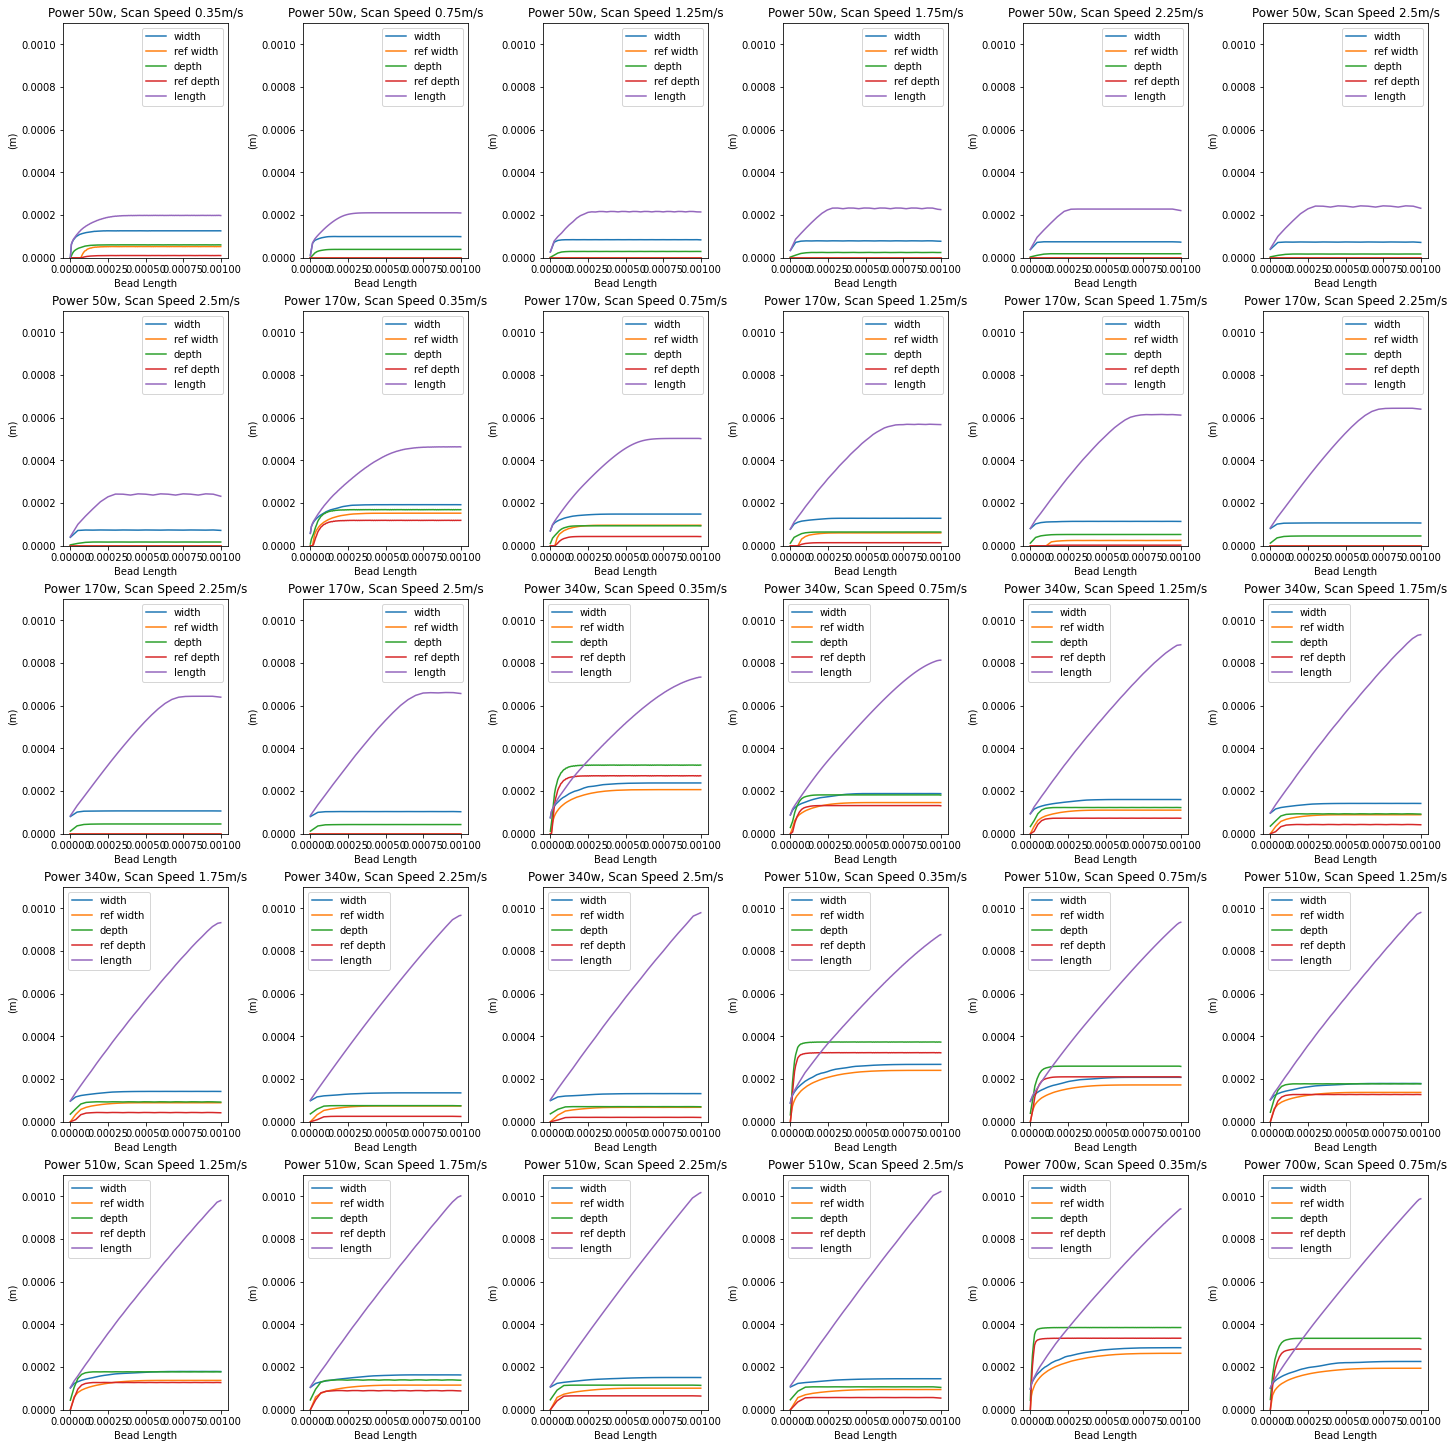

In [4]:
results.sort(key=lambda r : (r.machine.laser_power, r.machine.scan_speed))
# for r in range(len(results)):
#     print("power " + str(results[r].machine.laser_power) + ", scan speed " + str(results[r].machine.scan_speed))
# plt.style.use('_mpl-gallery')
# #fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
nrows = len(power_values)
ncols = len(velocity_values)
fig, axs = plt.subplots(nrows, ncols, figsize=(20, 20), layout='constrained')
for r in range(nrows):
    for c in range(ncols):
        i = r * nrows + c
        axs[r][c].plot(results[i].melt_pool.laser_x, results[i].melt_pool.width, label='width')
        axs[r][c].plot(results[i].melt_pool.laser_x, results[i].melt_pool.reference_width, label='ref width')
        axs[r][c].plot(results[i].melt_pool.laser_x, results[i].melt_pool.depth, label='depth')
        axs[r][c].plot(results[i].melt_pool.laser_x, results[i].melt_pool.reference_depth, label='ref depth')
        axs[r][c].plot(results[i].melt_pool.laser_x, results[i].melt_pool.length, label='length')
        axs[r][c].set_ylim(0, 1.1e-3)
        axs[r][c].legend()
        axs[r][c].set_xlabel(f'Bead Length')  # Add an x-label to the axes.
        axs[r][c].set_ylabel(f'(m)')  # Add a y-label to the axes.
        title = "Power " + str(results[i].machine.laser_power) + "w, Scan Speed " + str(results[i].machine.scan_speed) + "m/s"
        axs[r][c].set_title(title)  # Add a title to the axes.

In [5]:
powers = []
velocities = []
dw = []
lw = []

for r in results:
    m = r.melt_pool
    m.ave_length = np.average(m.length)
    m.ave_width = np.average(m.width)
    m.ave_depth = np.average(m.depth)
    m.ave_reference_width = np.average(m.reference_width)
    m.ave_reference_depth = np.average(m.reference_depth)
    powers.append(r.machine.laser_power)
    velocities.append(r.machine.scan_speed)
    dw.append(m.ave_depth / m.ave_width if m.ave_width else 0)
    lw.append(m.ave_length / m.ave_width if m.ave_width else 0)

Text(0, 0.5, 'Laser Power (w)')

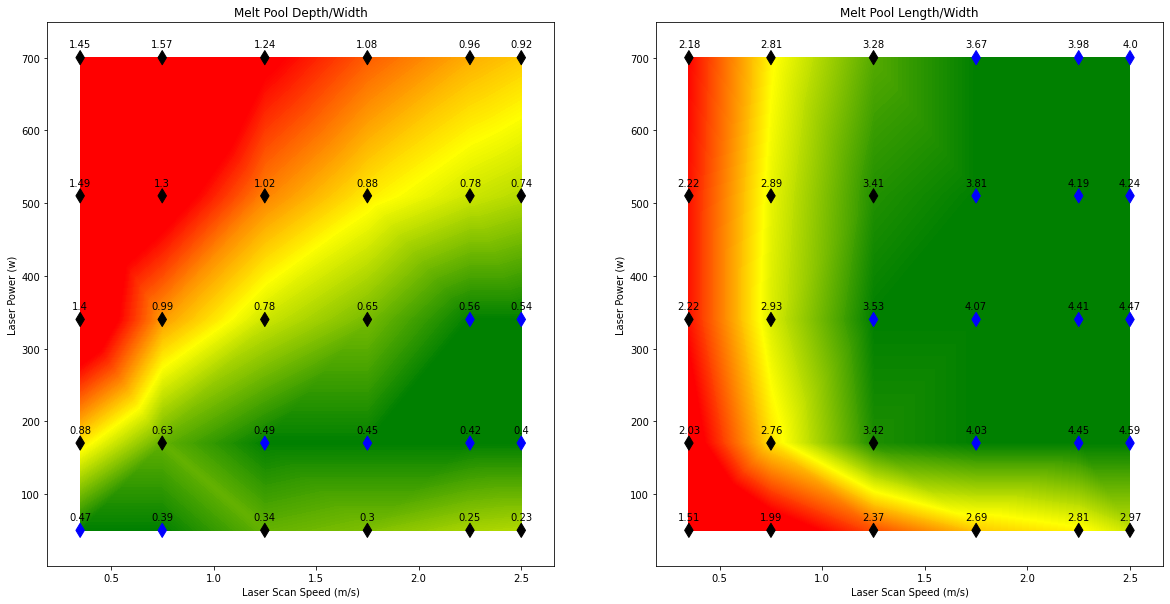

In [6]:
dwMin=0.37
dwMax=0.6
contour_gradient = []  # Someday switch this to numpy
marker_colors = []
fig, ax = plt.subplots(1, 2, figsize=(20,10))
for i in range(len(dw)):
    if dwMin < dw[i] < dwMax:
        contour_gradient.append(0)
        marker_colors.append('blue')
    else:
        contour_gradient.append(abs(((dwMax + dwMin) / 2) - dw[i]))
        marker_colors.append('black')
    txt = "{}".format(round(dw[i], 2))
    ax[0].annotate(str(txt), (velocities[i], powers[i] + 25), verticalalignment='top', horizontalalignment='center')

colMap = colorMap.from_list("", ["green", "yellow", "red", "red"])
ax[0].tricontourf(velocities, powers, contour_gradient, cmap=colMap, levels=255)
ax[0].scatter(velocities, powers, c=marker_colors, marker='d', s=100, facecolor='none')
ax[0].use_sticky_edges = False
ax[0].margins(0.075)
ax[0].set_title('Melt Pool Depth/Width')
ax[0].set_xlabel(f'Laser Scan Speed (m/s)')
ax[0].set_ylabel(f'Laser Power (w)')

lwMax = 3.5
contour_gradient = []
marker_colors = []
colMap = ['#ff0000ff', '#ff6600dd', '#ffff0022', '#00000000']
for i in range(len(lw)):
    if lw[i] > lwMax:
        contour_gradient.append(0)
        marker_colors.append('blue')
    else:
        contour_gradient.append(abs(lwMax - lw[i]))
        marker_colors.append('black')
    txt = "{}".format(round(lw[i], 2))
    ax[1].annotate(str(txt), (velocities[i], powers[i] + 25), verticalalignment='top', horizontalalignment='center')

# cmap = colorMap.from_list("", colMap)
cmap = colorMap.from_list("", ["green", "yellow", "red", "red"])
ax[1].tricontourf(velocities, powers, contour_gradient, cmap=cmap, levels=255)
ax[1].scatter(velocities, powers, c=marker_colors, marker='d', s=100, facecolor='none')
ax[1].use_sticky_edges = False
ax[1].margins(0.075)
ax[1].set_title('Melt Pool Length/Width')
ax[1].set_xlabel(f'Laser Scan Speed (m/s)')
ax[1].set_ylabel(f'Laser Power (w)')

 

In [7]:
pv_of_interest = []
for i in range(len(dw)):
    if dwMin < dw[i] < dwMax:
        pv_of_interest.append((powers[i], velocities[i]))

# valid hatch spacing: 6e-5 to 2e-4
hatch_spacing = [6e-5, 1e-4, 2e-4]
porosity_results = []
permutations = len(pv_of_interest) * len(hatch_spacing)
print(f'Starting {permutations} porosity simulations')
with concurrent.futures.ThreadPoolExecutor(8) as executor:
    futures = []
    completed = 0
    for x in pv_of_interest:
        for hs in hatch_spacing:
            machine = AdditiveMachine.default()
            machine.laser_power = x[0]
            machine.scan_speed = x[1]
            machine.hatch_spacing = hs
            input = PorosityInput(machine=machine, material=material, size_x=0.001, size_y=0.001, size_z=0.001)
            futures.append(executor.submit(additive.simulate_porosity, input, False))
    for future in concurrent.futures.as_completed(futures):
        completed += 1
        print(f'Completed {completed} of {permutations}')
        porosity_results.append(future.result())

# porosity_machine = AdditiveMachine.default()
# porosity_machine.laser_power = pv_of_interest[0][0]
# porosity_machine.scan_speed = pv_of_interest[0][1]
# porosity_input = PorosityInput(machine=porosity_machine, material=material, size_x=0.001, size_y=0.001, size_z=0.001)
# porosity_result = additive.simulate_porosity(porosity_input)
# print(porosity_result)


Starting 24 porosity simulations
Completed 1 of 24
Completed 2 of 24
Completed 3 of 24
Completed 4 of 24
Completed 5 of 24
Completed 6 of 24
Completed 7 of 24
Completed 8 of 24
Completed 9 of 24
Completed 10 of 24
Completed 11 of 24
Completed 12 of 24
Completed 13 of 24
Completed 14 of 24
Completed 15 of 24
Completed 16 of 24
Completed 17 of 24
Completed 18 of 24
Completed 19 of 24
Completed 20 of 24
Completed 21 of 24
Completed 22 of 24
Completed 23 of 24
Completed 24 of 24


In [8]:
def build_rate_cm_per_sec(scan_speed: float, hatch_spacing: float, layer_thickness: float) -> float:
    # convert all values to cm
    ss = scan_speed * 100
    hs = hatch_spacing * 100
    lt = layer_thickness * 100
    
    # calculate the time to scan a cubic centimeter
    n_layers = 1 / lt 
    lines_per_layer = 1 / hs
    return ss / (n_layers * lines_per_layer) # cc / sec

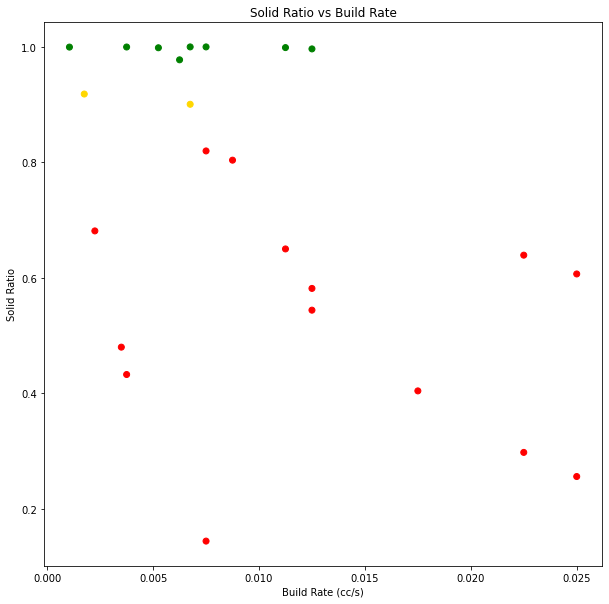

In [9]:
solid_ratios = [x.solid_ratio for x in porosity_results]
build_rates = [build_rate_cm_per_sec(x.scan_speed, x.hatch_spacing, x.layer_thickness) for x in porosity_results]
marker_colors = []
marker_green = 0.95
marker_yellow = 0.85
fig, ax = plt.subplots(figsize=(10,10))

# cmap = colorMap.from_list("", colMap)
# cmap = colorMap.from_list("", ["green", "yellow", "red", "red"])
# ax[1].tricontourf(velocities, powers, contour_gradient, cmap=cmap, levels=255)
# ax[1].scatter(velocities, powers, c=marker_colors, marker='d', s=100, facecolor='none')

ax.set(xlabel=f'Build Rate (cc/s)', ylabel=f'Solid Ratio', title='Solid Ratio vs Build Rate')
for i in range(len(solid_ratios)):
    if solid_ratios[i] > marker_green:
        marker_colors.append('green')
    elif solid_ratios[i] > marker_yellow:
        marker_colors.append('gold')
    else:
        marker_colors.append('red')
    txt = "{}".format(round(solid_ratios[i], 2))
    ax.annotate(str(txt), (build_rates[i], solid_ratios[i] + 25), xycoords='data', color='black', verticalalignment='top', horizontalalignment='center')
ax.scatter(build_rates, solid_ratios, c=marker_colors, facecolor='none')

plt.show()

In [10]:
porosity_of_interest = [x for x in porosity_results if x.solid_ratio > 0.98 ]



In [11]:
machine = AdditiveMachine.default()
machine.beam_diameter = porosity_of_interest[0].beam_diameter
machine.hatch_spacing = porosity_of_interest[0].hatch_spacing
machine.heater_temperature = porosity_of_interest[0].heater_temperature
machine.laser_power = porosity_of_interest[0].laser_power
machine.layer_rotation_angle = porosity_of_interest[0].layer_rotation_angle
machine.layer_thickness = porosity_of_interest[0].layer_thickness
machine.scan_speed = porosity_of_interest[0].scan_speed
machine.slicing_stripe_width = porosity_of_interest[0].slicing_stripe_width
machine.starting_layer_angle = porosity_of_interest[0].starting_layer_angle
input = MicrostructureInput(machine=machine, material=material)
microstructure_result = additive.simulate_microstructure(input)

Calculating microstructure: 100%|████████████████████████████████████████████████████| 100/100 [00:25<00:00,  4.00it/s]


In [12]:
def normalize(x):
    x = np.asarray(x)
    return (x - x.min()) / (np.ptp(x))


In [13]:
import pickle
with open('microstructure-result.bin', 'wb') as um_file:
    pickle.dump(microstructure_result, um_file)

In [14]:
import pickle
with open('microstructure-result.bin', "rb") as infile:
    um_reconstructed = pickle.load(infile)

In [15]:
import pyvista as pv
with open("xy.vtk", "wb") as xy_vtk:
    xy_vtk.write(um_reconstructed.xy_vtk)
with open("xz.vtk", "wb") as xz_vtk:
    xz_vtk.write(um_reconstructed.xz_vtk)
with open("yz.vtk", "wb") as yz_vtk:
    yz_vtk.write(um_reconstructed.yz_vtk)
xy = pv.read("xy.vtk")
xz = pv.read("xz.vtk")
yz = pv.read("yz.vtk")

In [16]:
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap as colorMap
from matplotlib.ticker import PercentFormatter
import pyvista as pv

def plot_microstructure(xy_data: any, xz_data: any, yz_data: any, scalars: str, cmap: colors.LinearSegmentedColormap):
    
    font_size = 8
    plotter = pv.Plotter(shape=(2,2), notebook=True, lighting='three lights')
    plotter.show_axes_all()
    plotter.add_mesh(xy_data, cmap=cmap, scalars=scalars)
    plotter.add_title('XY Plane', font_size=font_size)
    
    plotter.subplot(0,1)
    plotter.add_mesh(xz_data, cmap=cmap, scalars=scalars)
    plotter.add_title('XZ Plane', font_size=font_size)

    plotter.subplot(1,0)
    plotter.add_mesh(yz_data, cmap=cmap, scalars=scalars)
    plotter.add_title('YZ Plane', font_size=font_size)
    
    plotter.subplot(1,1)
    plotter.add_mesh(xy_data, cmap=cmap, scalars=scalars)
    plotter.add_mesh(xz_data, cmap=cmap, scalars=scalars)
    plotter.add_mesh(yz_data, cmap=cmap, scalars=scalars)
    plotter.add_title('Combined', font_size=font_size)

    return plotter


white_black_cmap = colorMap.from_list("whiteblack", ['white', 'black'])


In [20]:
p0 = plot_microstructure(xy, xz, yz, "GrainBoundaries", white_black_cmap)
p0.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [22]:
p1 = plot_microstructure(xy, xz, yz, "Orientation_(deg)", 'spectral')
p1.show()


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [19]:
p2 = plot_microstructure(xy, xz, yz, "GrainNumber", None)
p2.show()


ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)